In [1]:
import pandas as pd
import numpy as np
from scipy.special import gamma
from hurst import compute_Hc, random_walk
from statsmodels.tsa.stattools import acf
from math import log
from statsmodels.tsa.ar_model import AutoReg
def prepare_data(path):
    df = pd.read_csv(path)
    df.columns = ['Date_vix']
    df['Date'] = df['Date_vix'].apply(lambda x: x[0:8])
    df['vix'] = df['Date_vix'].apply(lambda x: x[9:])
    df['vix'] = df['vix'].apply(lambda x: str.replace(x, ' ', ''))
    df['vix'] = df['vix'].apply(lambda x: 0.0 if x == '.' else x)
    df['vix'] = df['vix'].astype(float)
    df['log_vix'] = np.log(df['vix'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


def obtain_train(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    value_first = df_ori['log_vix'].values[0]
    df_ori['log_vix'] = df_ori['log_vix'] - value_first
    df_ori['log_vix_mean'] =  df_ori['log_vix'].mean()
    df_ori['lr'] = 2 * np.linspace(0, 1, n) * df_ori['log_vix'].mean()
    df_ori['x'] = df_ori['log_vix'] - df_ori['lr']
    df_ori['y'] = df_ori['x'].diff()
    
    return df_ori,value_first


def obtain_train_ar(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

def obtain_gamma(value):
    value_ = np.power(gamma((value + 1) / 2), 2) / gamma(value + 0.5)
    return value_ / np.sqrt(np.pi)


def obtain_lambda(target):
    left = 0
    right = 3
    mid = (left + right) / 2
    while abs(obtain_gamma(mid) - target) > 10 ** -8:
        if obtain_gamma(mid) > target:
            left = mid
            mid = (left + right) / 2
        elif obtain_gamma(mid) < target:
            right = mid
            mid = (left + right) / 2
        else:
            return mid
    return mid

def obtain_params_by_ar(df_):
    acf_params_ = acf(df_['log_vix'],nlags=50)
    model_ = AutoReg(df_['log_vix'], lags=len(acf_params_[acf_params_>0.5])).fit()
    return model_.params


def objective_function(x, a,b):
    err = []
    for i in range(len(a)-1):
        err.append(np.power(a[i+1]-x[0]*a[i]-x[1]*b[i+1]-x[2],2)) # 可以加入对过去的多个依赖
    # print(err)
    return np.sum(err) #np.sqrt(np.sum(err))

from scipy.optimize import minimize, LinearConstraint

In [2]:
def obtain_true(df,n,date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    value_first = df_ori['log_vix'].values[0]
    df_ori['log_vix'] = df_ori['log_vix'] - value_first

    return df_ori,value_first

def obtain_true_ar(df,n,date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

In [3]:
def hmse(y_true,y_pred):
    ratio = y_pred/y_true

    # print(ratio[abs(ratio)<2])
    return np.mean(np.power((ratio[abs(ratio)<2]-1),2))

def hmae(y_true,y_pred):
    ratio = y_pred/y_true

    # print(ratio[abs(ratio)<2])
    return np.mean(abs(ratio[abs(ratio)<2]-1))

In [4]:



def calculate_aic(n, mse, num_params):
    """
    compute aic
    :param n:
    :param mse:
    :param num_params:
    :return:
    """
    aic = n * log(mse) + 2 * num_params
    return aic


def calculate_bic(n, mse, num_params):
    """
    compute bic
    :param n:
    :param mse:
    :param num_params:
    :return:
    """
    bic = n * log(mse) + num_params * log(n)
    return bic



In [5]:
def obtain_v(n,data,H):
    S = np.zeros([n+1,n+1])
    for i in range(1,n+1):
        for j in range(1,n+1):
            S[i][j] = (np.power(i,2*H)+ np.power(j,2*H) -np.power(np.power(j-i,2),H))/2
    S = S[1:,1:]
    A = S[0:n-1,0:n-1]
    A_ = np.linalg.inv(A)
    B_T = S[-1,0:n-1]

    v = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]-data['u'].values[-1]
    return v

In [6]:
def obtain_params(data):
    log_vix = data['log_vix'].values
    z_i = data['z_i'].values
    res = minimize(
    objective_function,
    x0=0.5 * np.random.random(3),
    args=(log_vix,z_i),
)
    return res

In [7]:
def predict_self(data,v,x,lambda_):
    z = np.sign(v)*np.power(abs(v),lambda_)
    result = data['y'].values[-1]*x[0]+z*x[1]+x[2]    #####
    return result


In [8]:
def main(date, n = 500):
    df = prepare_data('./data/VIXdata.txt')
    df_ori,value_first = obtain_train(df,n,date)
    df_ = df_ori.dropna()
    #
    # log_vix_t_1 = df_['log_vix'].values[-1]+value_first
    df_['abs_y'] = np.abs(df_['y'])
    df_['squared'] = df_['y']*df_['y']
    R1n = df_['abs_y'].mean()
    R2n = df_['squared'].mean()
    lambda_ = obtain_lambda(R1n*R1n/R2n)
    df_['y_tilde'] = np.sign(df_['y'])*np.power(df_['abs_y'],1/lambda_)
    df_['u'] = np.cumsum(df_['y_tilde'])
    df_['z_i'] = df_[['y','y_tilde']].apply(lambda x:np.sign(x[0])*np.power(abs(x[1]),lambda_),axis=1)
    series = df_['u'].values  # create a random walk from random changes
    # Evaluate Hurst equation
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    v = obtain_v(n,df_,H)
    res = obtain_params(df_)
    x = res.x
    result = predict_self(df_,v,x,lambda_)
    df_true,value_first_ = obtain_true(df,n+1,date)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]+value_first_
    log_vix_t_1 = df_true['log_vix'].values[-2]+value_first_
    # print(log_vix_t_1)
    # print(x,log_vix_t_1,result[0])
    return [result[0]+df_['x'].values[-1]+2*df_['log_vix_mean'].values[-1]+value_first_, date_,true_value,H,x[0],x[1],x[2],lambda_,res.fun],df_,value_first

In [9]:
aa,bb,cc = main('20160201',n=500)

C:\Users\gaoxc\anaconda3\envs\papers\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaoxc\AppData\Local\Temp\ipykernel_14184\4266083032.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaoxc\AppData\Local\Temp\ipykernel_14184\4266083032.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaoxc\AppData\Local\Te

In [10]:
aa 

[2.4697045917986467,
 numpy.datetime64('2018-01-25T00:00:00.000000000'),
 2.449279472144849,
 0.40500079295266556,
 0.9999998830701169,
 0.999999920658767,
 -0.0018329653306760946,
 1.519265502691269,
 3.4035109303255146e-13]

In [11]:
gamma_value = aa[5]
beta_value = aa[4]
omega_value = aa[6]
loss = aa[8]
loss

3.4035109303255146e-13

In [12]:
bb['z_i_shift'] = bb['z_i'].shift(-1)
bb  = bb.dropna()
bb 

,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift
1,20160202 21.98,2016-02-02,21.98,0.095401,-0.45731,-0.001833,0.097234,0.097234,0.097234,0.009454,0.215660,0.215660,0.097234,-0.013295
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159


In [13]:
bb['predict'] = bb['log_vix']*beta_value+gamma_value*bb['z_i_shift']+omega_value
bb 


,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift,predict
1,20160202 21.98,2016-02-02,21.98,0.095401,-0.45731,-0.001833,0.097234,0.097234,0.097234,0.009454,0.215660,0.215660,0.097234,-0.013295,0.080274
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571,0.089011
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971,0.157149
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048,0.263365
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389,0.283921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528,-0.491658
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097,-0.572587
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693,-0.594113
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159,-0.587787


In [14]:
beta_value

0.9999998830701169

In [15]:
gamma_value

0.999999920658767

In [16]:
omega_value

-0.0018329653306760946

In [17]:
bb['predict_shift'] = bb['predict'].shift(1)
bb 


,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift,predict,predict_shift
1,20160202 21.98,2016-02-02,21.98,0.095401,-0.45731,-0.001833,0.097234,0.097234,0.097234,0.009454,0.215660,0.215660,0.097234,-0.013295,0.080274,NaN
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571,0.089011,0.080274
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971,0.157149,0.089011
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048,0.263365,0.157149
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389,0.283921,0.263365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528,-0.491658,-0.517353
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097,-0.572587,-0.491658
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693,-0.594113,-0.572587
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159,-0.587787,-0.594113


In [18]:
bb = bb.dropna()
bb 

,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift,predict,predict_shift
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571,0.089011,0.080274
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971,0.157149,0.089011
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048,0.263365,0.157149
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389,0.283921,0.263365
6,20160209 26.54,2016-02-09,26.54,0.283921,-0.45731,-0.010997,0.294919,0.022389,0.022389,0.000501,0.082031,0.694362,0.022389,-0.007631,0.274457,0.283921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528,-0.491658,-0.517353
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097,-0.572587,-0.491658
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693,-0.594113,-0.572587
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159,-0.587787,-0.594113


In [19]:
# r2_score(bb['log_vix'].values,bb['predict_shift'].values)

In [20]:
df = prepare_data('./data/VIXdata.txt')
df[df['Date']>='2012-02-01']['Date'].values

C:\Users\gaoxc\anaconda3\envs\papers\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array(['2012-02-01T00:00:00.000000000', '2012-02-02T00:00:00.000000000',
       '2012-02-03T00:00:00.000000000', ...,
       '2022-07-27T00:00:00.000000000', '2022-07-28T00:00:00.000000000',
       '2022-07-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
df = prepare_data('./data/VIXdata.txt')
n = 150
date_list = [str.replace(str(x),'-','')[:8] for x in  df[df['Date']>='2012-02-01']['Date'].values[0:500] ]
result = []
for date in date_list:
    result_,_,a_ = main(date,n=n)
    result.append(result_)
result

C:\Users\gaoxc\anaconda3\envs\papers\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaoxc\anaconda3\envs\papers\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaoxc\AppData\Local\Temp\ipykernel_14184\4266083032.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaoxc\AppData\Local\Temp\ipykernel_14184\4266083032.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

[[2.9132330006565543,
  numpy.datetime64('2012-09-05T00:00:00.000000000'),
  2.8758219768814333,
  0.42413650328368524,
  0.9999999803360948,
  0.9999999834799006,
  -0.0003731975528701494,
  1.0237903743982315,
  9.345038387464915e-15],
 [2.861298141964261,
  numpy.datetime64('2012-09-06T00:00:00.000000000'),
  2.747270914255491,
  0.4270659181776566,
  0.9999999924873135,
  0.9999999886624039,
  4.173064004944618e-05,
  1.0305702835321426,
  8.412068810604369e-15],
 [2.629047502422915,
  numpy.datetime64('2012-09-07T00:00:00.000000000'),
  2.6658383522929006,
  0.4324083134492877,
  1.0000000109347218,
  0.9999999956118714,
  0.0007026021220420439,
  1.0357132852077484,
  8.609585754645224e-15],
 [2.5959877890457124,
  numpy.datetime64('2012-09-10T00:00:00.000000000'),
  2.7899373605743945,
  0.43052900079379464,
  1.0000019902408332,
  1.0000045405611084,
  0.0001787582378014364,
  1.0296638309955597,
  1.9506764322860056e-11],
 [2.9067159286919058,
  numpy.datetime64('2012-09-11T00

In [22]:
result_

[2.47746330724621,
 numpy.datetime64('2014-09-02T00:00:00.000000000'),
 2.505525936990736,
 0.40441081175735377,
 0.9999999129403792,
 0.9999999440825065,
 -0.0022095056629393797,
 1.3281421065330505,
 2.8859724704917284e-14]

In [23]:
from sklearn.metrics import mean_absolute_error,r2_score


In [24]:
df_result = pd.DataFrame(result,columns=['pred','date','true','H','beta','gamma','omega','lambda','loss'])
df_result

,pred,date,true,H,beta,gamma,omega,lambda,loss
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15
...,...,...,...,...,...,...,...,...,...
495,2.479296,2014-08-26,2.453588,0.609232,1.000000,1.000000,0.000668,1.328015,8.567378e-15
496,2.446898,2014-08-27,2.466403,0.560856,1.000000,1.000000,-0.000280,1.351382,9.185132e-15
497,2.478346,2014-08-28,2.489065,0.321238,1.000000,1.000000,-0.003993,1.314696,8.136280e-14
498,2.508183,2014-08-29,2.483239,0.334676,1.000000,1.000000,-0.003486,1.315516,6.270536e-14


In [25]:
df_result.to_csv("./beta_gamma_omega_0128_%s.txt"%n,sep='\t')

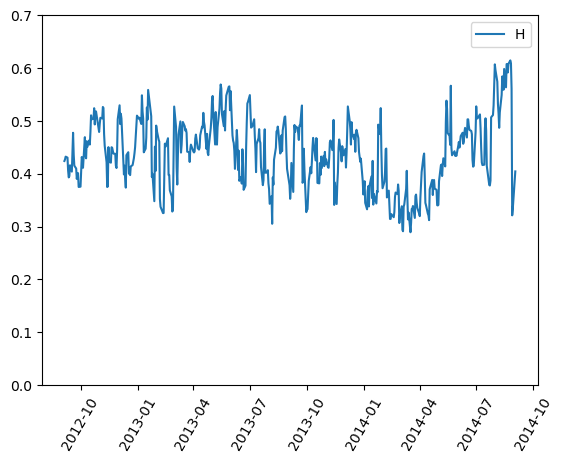

In [26]:
import matplotlib.pyplot as plt 
df_result['date'] = pd.to_datetime(df_result['date'])

plt.plot(df_result['date'],df_result['H'],label='H')
plt.xticks(rotation=60)
plt.legend()
plt.ylim(0,0.7)
plt.show()

In [27]:
r2 = r2_score(df_result['true'].values,df_result['pred'].values)
r2 

0.4577825198633205

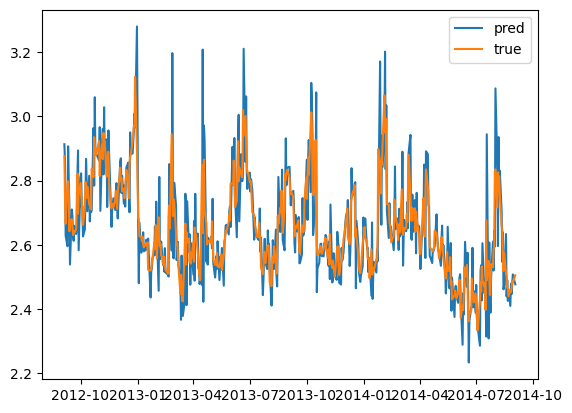

In [28]:
import matplotlib.pyplot as plt
plt.plot(df_result['date'],df_result['pred'],label='pred')
plt.plot(df_result['date'],df_result['true'],label='true')
plt.legend()
plt.show()

In [29]:
from statsmodels.tsa.ar_model import AutoReg

def ar(date,n=500):
    df = prepare_data('./data/VIXdata.txt')
    # date = '20120101'
    df_ori = obtain_train_ar(df,n,date)
    acf_params = acf(df_ori['log_vix'],nlags=50)
    model = AutoReg(df_ori['log_vix'], lags=len(acf_params[acf_params>0.5])).fit()
    result = model.forecast(1)

    df_true = obtain_true_ar(df,n+1,date)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
    print(type(result))
    # print()
    return [result.values[-1],date_,true_value,len(acf_params[acf_params>0.5])],model


In [30]:
date_list

['20120201',
 '20120202',
 '20120203',
 '20120206',
 '20120207',
 '20120208',
 '20120209',
 '20120210',
 '20120213',
 '20120214',
 '20120215',
 '20120216',
 '20120217',
 '20120221',
 '20120222',
 '20120223',
 '20120224',
 '20120227',
 '20120228',
 '20120229',
 '20120301',
 '20120302',
 '20120305',
 '20120306',
 '20120307',
 '20120308',
 '20120309',
 '20120312',
 '20120313',
 '20120314',
 '20120315',
 '20120316',
 '20120319',
 '20120320',
 '20120321',
 '20120322',
 '20120323',
 '20120326',
 '20120327',
 '20120328',
 '20120329',
 '20120330',
 '20120402',
 '20120403',
 '20120404',
 '20120405',
 '20120409',
 '20120410',
 '20120411',
 '20120412',
 '20120413',
 '20120416',
 '20120417',
 '20120418',
 '20120419',
 '20120420',
 '20120423',
 '20120424',
 '20120425',
 '20120426',
 '20120427',
 '20120430',
 '20120501',
 '20120502',
 '20120503',
 '20120504',
 '20120507',
 '20120508',
 '20120509',
 '20120510',
 '20120511',
 '20120514',
 '20120515',
 '20120516',
 '20120517',
 '20120518',
 '20120521',

In [ ]:
result_ar = []
for date in date_list:
    result_,model = ar(date,n=n)
    result_ar.append(result_)
result_ar
df_result_ar = pd.DataFrame(result_ar,columns=['pred','date','true','K'])

In [32]:
df_result_ar

,pred,date,true,K
0,2.884128,2012-09-05,2.875822,9
1,2.879716,2012-09-06,2.747271,9
2,2.752111,2012-09-07,2.665838,9
3,2.695543,2012-09-10,2.789937,10
4,2.805013,2012-09-11,2.797891,10
...,...,...,...,...
495,2.470383,2014-08-26,2.453588,7
496,2.463399,2014-08-27,2.466403,7
497,2.482532,2014-08-28,2.489065,7
498,2.490154,2014-08-29,2.483239,7


In [33]:
model.summary().as_text()

'                            AutoReg Model Results                             \n==============================================================================\nDep. Variable:                log_vix   No. Observations:                  150\nModel:                     AutoReg(6)   Log Likelihood                 203.066\nMethod:               Conditional MLE   S.D. of innovations              0.059\nDate:                Sat, 28 Jan 2023   AIC                           -390.132\nTime:                        19:17:34   BIC                           -366.373\nSample:                             6   HQIC                          -380.478\n                                  150                                         \n==============================================================================\n                 coef    std err          z      P>|z|      [0.025      0.975]\n------------------------------------------------------------------------------\nconst          0.3344      0.106      3

In [34]:
df_result_ar['date'] = pd.to_datetime(df_result_ar['date'])

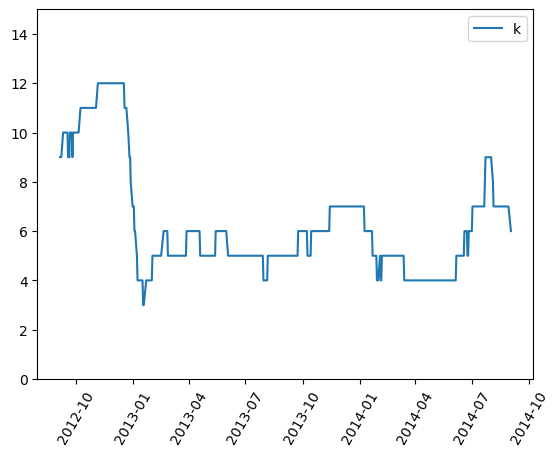

In [35]:
import matplotlib.pyplot as plt
plt.plot(df_result_ar['date'],df_result_ar['K'],label='k')
plt.xticks(rotation=60)
plt.legend()
plt.ylim(0,15)
plt.show()

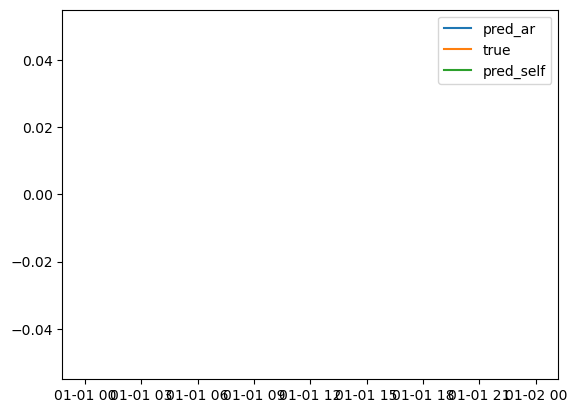

In [36]:
plt.plot(df_result_ar[df_result_ar['date']<'2012-04-01']['date'],
         df_result_ar[df_result_ar['date']<'2012-04-01']['pred'],label='pred_ar')
plt.plot(df_result_ar[df_result_ar['date']<'2012-04-01']['date'],
         df_result_ar[df_result_ar['date']<'2012-04-01']['true'],label='true')
plt.plot(df_result_ar[df_result_ar['date']<'2012-04-01']['date'],
         df_result[df_result['date']<'2012-04-01']['pred'],label='pred_self')
plt.legend()
plt.show()

In [37]:
r2_ar = r2_score(df_result_ar['true'].values,df_result_ar['pred'].values)
r2_ar

0.7548442770022457

In [38]:
df_result_ar['err'] = abs(df_result_ar['pred']-df_result_ar['true'])

In [39]:
(df_result_ar['err']*df_result_ar['err']).mean()

0.004582479525942847

In [40]:
df_result['err'] = abs(df_result['pred']-df_result['true'])
(df_result['err']*df_result['err']).mean()

0.010135192729550987

In [41]:
df_result['err'].mean()

0.0701124969389156

In [42]:
df_result_ar['err'].mean()

0.049081737010483704

In [43]:
from sklearn.metrics import r2_score

In [44]:
r2_score(df_result['true'],df_result['pred'])

0.4577825198633205

In [45]:
r2_score(df_result_ar['true'],df_result_ar['pred'])

0.7548442770022457

In [46]:
hmse(df_result_ar['true'],df_result_ar['pred'])

0.0006193006048058637

In [47]:
hmae(df_result_ar['true'],df_result_ar['pred'])

0.018328269391963862

In [48]:
hmse(df_result['true'],df_result['pred'])

0.0013804103551676263

In [49]:
hmae(df_result['true'],df_result['pred'])

0.026128723027383678

In [50]:
pd.DataFrame([[hmse(df_result['true'],df_result['pred']),
              hmae(df_result['true'],df_result['pred']),
              hmse(df_result_ar['true'],df_result_ar['pred']),
              hmae(df_result_ar['true'],df_result_ar['pred']),
              r2_score(df_result['true'],df_result['pred']),
              r2_score(df_result_ar['true'],df_result_ar['pred'])
              ]],columns = ['hmse_','hmae','hmse_ar','hmae_ar','r2_','r2_ar'])

,hmse_,hmae,hmse_ar,hmae_ar,r2_,r2_ar
0,0.00138,0.026129,0.000619,0.018328,0.457783,0.754844


In [51]:
# import numpy as np
# import matplotlib.pyplot as plt
#
# # Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)
#
# fig, ax1 = plt.subplots()
#
# # color = 'green'
# ax1.set_xlabel('date')
# # ax1.set_xticks(ratation=60)
# ax1.set_ylabel('H',color='r')
# ax1.plot(df_result['date'], df_result['H'],'-s',color='r')
# ax1.tick_params(axis='y')
# ax1.set_ylim((0.1,0.5))
#
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#
#
# ax2.set_ylabel('k',color='b')  # we already handled the x-label with ax1
# ax2.plot(df_result_ar['date'], df_result_ar['K'],'-^',color='b')
# ax2.tick_params(axis='y')
# ax2.set_ylim((0,20))
#
# for tl in ax1.get_xticklabels():
#     tl.set_rotation(45)
#
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.savefig("./H_k.png",dpi=200)
# plt.show()

In [52]:
# import numpy as np
# import matplotlib.pyplot as plt

# def function(x, p):
#     return x ** (2 * p + 1) / (1 + x ** (2 * p))

# pparam = dict(xlabel='Voltage (mV)', ylabel='Current ($\mu$A)')

# x = np.linspace(0.75, 1.25, 201)
# with plt.style.context(['science']):
#     fig, ax = plt.subplots()
#     for p in [10, 15, 20, 30, 50, 100]:
#         ax.plot(x, function(x, p), label=p)
#     ax.legend(title='Order')
#     ax.autoscale(tight=True)
#     ax.set(**pparam)
#     # fig.savefig('figures/fig1.pdf')
#     # fig.savefig('figures/fig1.jpg', dpi=300)


In [53]:
# df_result_all

In [54]:
colu1 = df_result.columns.tolist()
colu1 = [i+'_self' for i in colu1]
df_result.columns = colu1
df_result.head()

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825


In [55]:
colu2 = df_result_ar.columns.tolist()
colu2 = [i+'_ar' for i in colu2]
df_result_ar.columns = colu2
df_result_ar.head()

,pred_ar,date_ar,true_ar,K_ar,err_ar
0,2.884128,2012-09-05,2.875822,9,0.008306
1,2.879716,2012-09-06,2.747271,9,0.132445
2,2.752111,2012-09-07,2.665838,9,0.086273
3,2.695543,2012-09-10,2.789937,10,0.094394
4,2.805013,2012-09-11,2.797891,10,0.007122


In [56]:
df_result_all = pd.merge(df_result,df_result_ar,how='left',left_on=['date_self'],right_on=['date_ar'])
df_result_all.head()

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self,pred_ar,date_ar,true_ar,K_ar,err_ar
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411,2.884128,2012-09-05,2.875822,9,0.008306
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027,2.879716,2012-09-06,2.747271,9,0.132445
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791,2.752111,2012-09-07,2.665838,9,0.086273
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950,2.695543,2012-09-10,2.789937,10,0.094394
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825,2.805013,2012-09-11,2.797891,10,0.007122


In [57]:
df_result_all['err'] = df_result_all['err_self']+df_result_all['err_ar']

In [58]:
df_result_all.head()

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self,pred_ar,date_ar,true_ar,K_ar,err_ar,err
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411,2.884128,2012-09-05,2.875822,9,0.008306,0.045717
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027,2.879716,2012-09-06,2.747271,9,0.132445,0.246473
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791,2.752111,2012-09-07,2.665838,9,0.086273,0.123064
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950,2.695543,2012-09-10,2.789937,10,0.094394,0.288344
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825,2.805013,2012-09-11,2.797891,10,0.007122,0.115947


In [59]:
df_result_all = df_result_all[df_result_all['err']<0.3]

In [60]:
df_result_all

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self,pred_ar,date_ar,true_ar,K_ar,err_ar,err
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411,2.884128,2012-09-05,2.875822,9,0.008306,0.045717
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027,2.879716,2012-09-06,2.747271,9,0.132445,0.246473
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791,2.752111,2012-09-07,2.665838,9,0.086273,0.123064
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950,2.695543,2012-09-10,2.789937,10,0.094394,0.288344
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825,2.805013,2012-09-11,2.797891,10,0.007122,0.115947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.479296,2014-08-26,2.453588,0.609232,1.000000,1.000000,0.000668,1.328015,8.567378e-15,0.025708,2.470383,2014-08-26,2.453588,7,0.016795,0.042503
496,2.446898,2014-08-27,2.466403,0.560856,1.000000,1.000000,-0.000280,1.351382,9.185132e-15,0.019506,2.463399,2014-08-27,2.466403,7,0.003004,0.022509
497,2.478346,2014-08-28,2.489065,0.321238,1.000000,1.000000,-0.003993,1.314696,8.136280e-14,0.010718,2.482532,2014-08-28,2.489065,7,0.006532,0.017251
498,2.508183,2014-08-29,2.483239,0.334676,1.000000,1.000000,-0.003486,1.315516,6.270536e-14,0.024944,2.490154,2014-08-29,2.483239,7,0.006915,0.031860


In [61]:
pd.DataFrame([[hmse(df_result_all['true_self'],df_result_all['pred_self']),
              hmae(df_result_all['true_self'],df_result_all['pred_self']),
              hmse(df_result_all['true_ar'],df_result_all['pred_ar']),
              hmae(df_result_all['true_ar'],df_result_all['pred_ar']),
              r2_score(df_result_all['true_self'],df_result_all['pred_self']),
              r2_score(df_result_all['true_ar'],df_result_all['pred_ar'])
              ]],columns = ['hmse_','hmae','hmse_ar','hmae_ar','r2_','r2_ar'])

,hmse_,hmae,hmse_ar,hmae_ar,r2_,r2_ar
0,0.000775,0.021662,0.000415,0.015888,0.680777,0.830225


In [4]:
from statsmodels.tsa.ar_model import AutoReg

df = prepare_data('./data/VIXdata.txt')
date = '20120101'
n =500
df_ori = obtain_train_ar(df,n,date)
acf_params = acf(df_ori['log_vix'],nlags=50)
model = AutoReg(df_ori['log_vix'], lags=len(acf_params[acf_params>0.5])).fit()
result = model.forecast(1)

C:\Users\gaoxc\anaconda3\envs\papers\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
type(model.params)

pandas.core.series.Series

In [9]:
model.params['const']

0.17566654768773923

In [12]:
np.array(model.params)*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])

array([ 0.17566655,  1.62716087,  0.16275258,  0.17640345,  0.13004872,
       -0.46828656,  0.67465697, -0.24842408,  0.28376093, -0.17144288,
        0.30767221,  0.10902138, -0.44760793, -0.08968734])

In [13]:
np.dot(np.array(model.params),np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14]))

2.2216948647929113

In [14]:
model.predict()

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
495    2.659808
496    2.633531
497    2.585934
498    2.564617
499    2.531979
Length: 500, dtype: float64